In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(7777)

In [3]:
trend_train = np.arange(11,111, dtype='float64') + np.random.normal(scale=2, size=100)
trend_test_outofrange = np.arange(111,131, dtype='float64') + np.random.normal(scale=2, size=20)
trend_test_inrange = np.arange(31,51, dtype='float64') + np.random.normal(scale=2, size=20)

In [4]:
train = trend_train
test = trend_test_outofrange

In [5]:
lstm_stateful = True
lstm_num_timesteps = 4 # for diffed series
effective_timesteps = lstm_num_timesteps+1
lstm_num_features = 1
num_neurons = 4
batchsize = 1
num_epochs = 500

In [6]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return(diff)

def inverse_difference(history, yhat, interval=1):
    # history[-len(series)] is first item, history[-len(series) - 1] is second, etc. 
    return yhat + history[-interval]

In [7]:
train_diff = difference(train, 1)
test_diff = difference(test, 1)
test_diff

[0.27338302596317021,
 1.7310265497711441,
 1.7451128164638021,
 0.29727845971444822,
 -0.061718680499211587,
 2.0725813598952101,
 -3.0916986883747199,
 3.3959042561117627,
 5.4305546542064178,
 0.16910568625694111,
 0.90280661853361721,
 -0.65152964591959517,
 1.5494066806911633,
 -0.63092790701740853,
 2.8014413479762936,
 1.8094951282746763,
 -0.45663481451620669,
 2.7467181214053369,
 -2.3186887828005354]

In [8]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


values = [x for x in range(10)]
data = series_to_supervised(values,3)
print(data)

   var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
3        0.0        1.0        2.0        3
4        1.0        2.0        3.0        4
5        2.0        3.0        4.0        5
6        3.0        4.0        5.0        6
7        4.0        5.0        6.0        7
8        5.0        6.0        7.0        8
9        6.0        7.0        8.0        9


In [9]:
train_diff_df = series_to_supervised(train_diff,lstm_num_timesteps)
test_diff_df = series_to_supervised(test_diff,lstm_num_timesteps)
test_diff_df

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
4,0.273383,1.731027,1.745113,0.297278,-0.061719
5,1.731027,1.745113,0.297278,-0.061719,2.072581
6,1.745113,0.297278,-0.061719,2.072581,-3.091699
7,0.297278,-0.061719,2.072581,-3.091699,3.395904
8,-0.061719,2.072581,-3.091699,3.395904,5.430555
9,2.072581,-3.091699,3.395904,5.430555,0.169106
10,-3.091699,3.395904,5.430555,0.169106,0.902807
11,3.395904,5.430555,0.169106,0.902807,-0.651530
12,5.430555,0.169106,0.902807,-0.651530,1.549407
13,0.169106,0.902807,-0.651530,1.549407,-0.630928


In [10]:
train_diff_matrix = train_diff_df.values
test_diff_matrix = test_diff_df.values

In [11]:
train_diff_matrix[:5,:]

array([[ 1.72704053, -0.71318758,  0.79501148,  6.65996568, -2.59368682],
       [-0.71318758,  0.79501148,  6.65996568, -2.59368682, -1.71367586],
       [ 0.79501148,  6.65996568, -2.59368682, -1.71367586,  2.74897887],
       [ 6.65996568, -2.59368682, -1.71367586,  2.74897887,  0.11040753],
       [-2.59368682, -1.71367586,  2.74897887,  0.11040753,  1.57467113]])

In [12]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


In [13]:
scaler, train_scaled, test_scaled = scale(train_diff_matrix, test_diff_matrix)
test_scaled

array([[ 0.15835973,  0.34382199,  0.34561424,  0.16140005,  0.11572329],
       [ 0.34382199,  0.34561424,  0.16140005,  0.11572329,  0.38727948],
       [ 0.34561424,  0.16140005,  0.11572329,  0.38727948, -0.26979411],
       [ 0.16140005,  0.11572329,  0.38727948, -0.26979411,  0.55565155],
       [ 0.11572329,  0.38727948, -0.26979411,  0.55565155,  0.81452888],
       [ 0.38727948, -0.26979411,  0.55565155,  0.81452888,  0.14509207],
       [-0.26979411,  0.55565155,  0.81452888,  0.14509207,  0.238444  ],
       [ 0.55565155,  0.81452888,  0.14509207,  0.238444  ,  0.04067911],
       [ 0.81452888,  0.14509207,  0.238444  ,  0.04067911,  0.32071371],
       [ 0.14509207,  0.238444  ,  0.04067911,  0.32071371,  0.04330035],
       [ 0.238444  ,  0.04067911,  0.32071371,  0.04330035,  0.48001547],
       [ 0.04067911,  0.32071371,  0.04330035,  0.48001547,  0.35380588],
       [ 0.32071371,  0.04330035,  0.48001547,  0.35380588,  0.06547641],
       [ 0.04330035,  0.48001547,  0.3

In [14]:
def fit_lstm_stateful(train, batchsize, num_epochs, num_neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], lstm_num_timesteps, lstm_num_features))
    model = Sequential()
    model.add(LSTM(num_neurons, batch_input_shape=(batchsize, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    for i in range(num_epochs):
        model.fit(X, y, epochs=1, batch_size=batchsize, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [15]:
def fit_lstm_stateless(train, batchsize, num_epochs, num_neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], lstm_num_timesteps, lstm_num_features))
    model = Sequential()
    model.add(LSTM(num_neurons, batch_input_shape=(batchsize, X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    model.fit(X, y, epochs=num_epochs, batch_size=batchsize, verbose=1, shuffle=True)
    return model

In [16]:
def forecast_lstm(model, batch_size, X):
    if lstm_stateful:
         model.reset_states()
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [17]:
train_diff = difference(train, 1)
test_diff = difference(test, 1)
train_matrix = series_to_supervised(train_diff, lstm_num_timesteps).values
test_matrix = series_to_supervised(test_diff, lstm_num_timesteps).values
scaler, train_scaled, test_scaled = scale(train_matrix, test_matrix)

if lstm_stateful:
    lstm_model = fit_lstm_stateful(train_scaled, batchsize, num_epochs, num_neurons)
else:
    lstm_model = fit_lstm_stateless(train_scaled, batchsize, num_epochs, num_neurons)
        
train_predictions = list()
for i in range(len(train_scaled)):
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(train, yhat, len(train_scaled)+1-i)
    train_predictions.append(yhat)
            
test_predictions = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(test, yhat, len(test_scaled)+1-i)
    test_predictions.append(yhat)
         
rmse = sqrt(mean_squared_error(test[effective_timesteps:], test_predictions))
print('Test RMSE: %.3f' % rmse)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1837     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1488     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1394     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1359     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1330     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1300     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1270     
Epoch 1/1
95/95 [=====

In [18]:
test_predictions[:10]

[114.31216783952888,
 114.79609132408858,
 115.99834677937967,
 115.52983712916939,
 116.39740440367744,
 119.47846720243619,
 121.18368668390588,
 122.21773057786841,
 123.1083820338778,
 124.26658436914587]

In [19]:
train_predictions[:10]

[17.16739258119274,
 17.807344958130088,
 17.376940536541454,
 18.248238764272656,
 19.24263207437648,
 19.848031136893191,
 20.050593176952596,
 20.652398230811034,
 22.412956547561446,
 23.040026774587055]

In [20]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    padding = [np.nan for i in range(effective_timesteps)]
    plt.plot(padding + predicted_data, label='Prediction')
    plt.legend()
    plt.show()

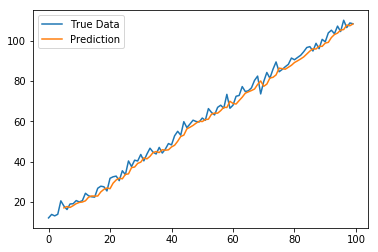

In [21]:
plot_results(train_predictions, train)

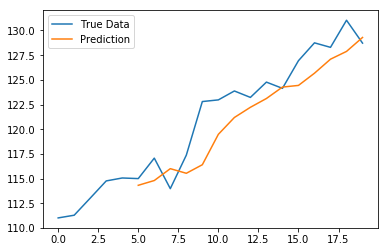

In [22]:
plot_results(test_predictions, test)